In [1]:
import os

openai_api_key=os.getenv("openai_api_key")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv('deployment_name')
AZURE_OPENAI_ENDPOINT = os.getenv("endpoint")
AZURE_OPENAI_API_VERSION = os.getenv("version")

In [2]:
groq_api_key = os.getenv("groq_api_key")
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key)

In [3]:
from langchain.chat_models import AzureChatOpenAI

llm= AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    openai_api_base=AZURE_OPENAI_ENDPOINT,
    openai_api_key=openai_api_key,
    openai_api_version=AZURE_OPENAI_API_VERSION
)

C:\Users\yash2\AppData\Local\Temp\ipykernel_12144\3069890798.py:3: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm= AzureChatOpenAI(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://soa-openai-sc.openai.azure.com/ to https://soa-openai-sc.openai.azure.com/openai.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specifi

In [4]:
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper(
    k=2
)

google_search = Tool(
    name="google_search",
    func=search.run,
    description="Search Engine",
    max_tokens=500
)

In [5]:
from typing import List, Dict, Optional
from pydantic import BaseModel, Field, validator

class Enrich(BaseModel):
    Product: Optional[str]=Field(description="Name/Type of the product in the query", default="N/A"),
    Dimension: Optional[str]=Field(description="Dimension of product", default="N/A"),
    Enriched_Query: Optional[str]=Field(description="Reformulate the user query into a well-defined and detailed format by utilizing both the query and the provided context.", default="N/A")

class MatchResult(BaseModel):
    Product: bool = Field(description="Does product matched, true or false.", default=False)
    Dimension: bool = Field(description="Does dimension of product matched, true or false.", default=False)
    Numerical_Entities: Optional[List[str]] = Field(
        description="list of the numerical entities",
        default_factory=list
    )
    Non_Numerical_Entities: Optional[List[str]] = Field(
        description="list of non-numerical entities",
        default_factory=list
    )

    @validator('Numerical_Entities', pre=True)
    def convert_numerical_to_str(cls, v):
        if v is None:
            return []
        return [str(x) for x in v]

class ProductDetails(BaseModel):
    Product_id: str=Field(description="Product id")
    description: str=Field(description="Description of the product")
    Matching_Numerical_Entities: Optional[int] = Field(description="Number of Matching Numerical Entities", default=0)
    Matching_Non_Numerical_Entities: Optional[int] = Field(description="Number of matched non-numerical entities", default=0)

class Product(BaseModel):
    Product_id: Optional[str]
    Manufacturer_Part_No: Optional[str] = Field(alias="Manufacturer Part No. ")
    description: Optional[str]
    stock_type: Optional[int]
    additional_information: Optional[Dict[str, str]]=Field(default_factory={})

class State(BaseModel):
    query: str
    context: Optional[str]
    output_1: Optional[Enrich]
    products_list: List[Product]
    t_n_f_list: Optional[List[MatchResult]]
    output_2: Optional[List[ProductDetails]] 


C:\Users\yash2\AppData\Local\Temp\ipykernel_12144\3224670667.py:21: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('Numerical_Entities', pre=True)


In [6]:
def google(state:State)->str:
    return {"context":google_search.invoke(state.query)}

In [7]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate


In [8]:
google_search.invoke("2 in x 2 in x 3/4 in thrd tee C.S")

'... x Socket x ... 2 x 1/2 x 1/8-Inch (50/Cs). Login to view price. Product Image. 128070507 PVC Reducing Tee Fitting - Schedule 40 - Socket x Socket x Thread - 3/4\xa0... 3FST1FF 1 1/2 X 1/2 3M# FS THR TEE A105. 1-1/2 x 3/4 in REDUCER TEE. 3FST1FF 1 1/2 X 1/2 3M# FS THR TEE A105. Log In for Pricing and Availability · 3FS902F 2 1/\xa0...'

In [9]:
def query_enrich(state: State) -> Dict[str, str]:
    system_prompt = f"""
        You are given a product description along with some context. Your task is to extract relevant information and return it as a structured. It should include fields such as the product's quantity, name, and no additional details that can be inferred from the context.
        Only give the output, no description is needed.
        Query:{state.query}
        Context:{state.context}
        Output:
        Product:(Name/Type of the product in the query),
        Dimension:(Dimension of product),
        Enriched_Query:(Reformulate the user query into a well-defined and detailed format by utilizing both the query and the provided context.),

        Example:
        Query:"1 9 Puma white"
        Context: "
        MUST INCLUDE THESE THREE PARAMETERS IN OUTPUT.
        """

    parser = JsonOutputParser(pydantic_object=Enrich)

    prompt = PromptTemplate(
        template="""
            Information: {enr}
            In format: {format}
        """,
        input_variables=["enr"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "enr": llm.invoke(system_prompt).content
    })

    # Create output_1 using dot notation to access the Pydantic model attributes
    # output_1 = enrich(
    #     Product=response.Product,
    #     Dimension=response.Dimension,
    #     Enriched_Query=response.Enriched_Query
    # )

    return {"output_1": response}

In [10]:
def query_enrich_1():
    system_prompt = f"""
        You are given a product description along with some context. Your task is to extract relevant information and return it as a structured. It should include fields such as the product's quantity, name, and no additional details that can be inferred from the context.
        Only give the output.
        Query:2 x 2 x 3/4 thrd tee C.S
        Context:{google_search.invoke("2 in x 2 in x 3/4 in thrd tee C.S")}
        Output:
        Product:(Name/Type of the product in the query),
        Dimension:(Dimension of product),
        Enriched_Query:(Reformulate the user query into a well-defined and detailed format by utilizing both the query and the provided context.),
        
        MUST INCLUDE THESE THREE PARAMETERS IN OUTPUT.
        """

    parser = JsonOutputParser(pydantic_object=Enrich)

    prompt = PromptTemplate(
        template="""
            Information: {enr}
            In format: {format}
        """,
        input_variables=["enr"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "enr": llm.invoke(system_prompt).content
    })

    # Create output_1 using dot notation to access the Pydantic model attributes
    # output_1 = enrich(
    #     Product=response.Product,
    #     Dimension=response.Dimension,
    #     Enriched_Query=response.Enriched_Query
    # )

    return response

In [11]:
res=query_enrich_1()

d:\Yash-Python\Lib\site-packages\pydantic\json_schema.py:2179: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default='N/A', description='Name/Type of the product in the query'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
d:\Yash-Python\Lib\site-packages\pydantic\json_schema.py:2179: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default='N/A', description='Dimension of product'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [12]:
print(res)

{'Product': 'Tee', 'Dimension': '2 x 2 x 3/4', 'Enriched_Query': '2 x 2 x 3/4 inch threaded tee made of Carbon Steel (C.S)'}


In [13]:
def product_find(state: State)-> List[Dict[str,str]]:
    system_prompt = """
        You are an expert at matching user queries with inventory items. Given a set of **product details** from a user and an **inventory list** of products, evaluate if the user-provided details match the items in the inventory. For a match to be valid, the following conditions must be met:

        1) The **dimensions** of the product in the inventory must exactly match the dimensions provided by the user, in the same order and format, with no additions or omissions.
        2) The **product name** in the inventory may have similar context match with the product name or enriched query specified by the user.

        **User-Provided Product Details:**
        Product Name:{name}
        Product Dimension:{dimension}
        Enriched Query: {Query}

        **Inventory List:**
        {inventory}
        
        **Expected Output:**
        Product: true/false, 
        Dimension: true/false

        ONLY GIVE OUTPUT IN THE GIVEN FORMAT, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
    """
    system_prompt_1 = """
        You are an expert data analyzer. Your task is to extract and classify entities from a given query into two categories: **numerical entities** and **non-numerical entities**. Provide the results strictly in the following format below:

        Input Query: 
        {Input_Query}

        Output:
        Numerical_Entities: list of numerical entities (Use N/A if not found)
        Non_Numerical_Entities: list of unique non-numerical entities (Use N/A if not found)

        ### Example:

        Input Query: 
        10 quantities of 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.)

        Output:
        Numerical_Entities: [10, 2-inch by 2-inch by 3/4-inch],
        Non_Numerical_Entities: ["threaded tee fitting", "carbon steel"]

        ONLY GIVE OUTPUT. DO NOT INCLUDE EXTRA INFORMATION, SYMBOLS, OR TEXT.
    """
    parser = JsonOutputParser(pydantic_object=MatchResult)
    template = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
    ])

    template_1 = ChatPromptTemplate.from_messages([
        ("system", system_prompt_1)
    ])
    
    # Use dot notation to access Pydantic model attributes
    prompt_value_1 = template_1.invoke(
        {
            "Input_Query": state.output_1.Enriched_Query  # Changed from dictionary access to dot notation
        }
    )
    response_1 = llm.invoke(prompt_value_1).content
    output = []
    
    for prod_list in state.products_list:
        prompt_value = template.invoke(
            {
                "name": state.output_1.Product,  # Changed from dictionary access to dot notation
                "dimension": state.output_1.Dimension, 
                 "Query": state.output_1.Enriched_Query, # Changed from dictionary access to dot notation
                "inventory": {
                    "Product_id": prod_list.Product_id,
                    "Manufacturer_Part_No": prod_list.Manufacturer_Part_No,
                    "description": prod_list.description,
                    "stock_type": prod_list.stock_type,
                    "additional_information": prod_list.additional_information
                }
            }
        )
        response = llm.invoke(prompt_value).content

        prompt_val = PromptTemplate(
            template="{resp} and {resp_1}, in this {format}",
            input_variables=["resp", "resp_1"],
            partial_variables={"format": parser.get_format_instructions()}
        )
        chain = prompt_val | llm | parser

        output.append(chain.invoke({
            "resp": response,
            "resp_1": response_1
        }))
    
    return {"t_n_f_list": output}

In [14]:
def filter(state: State)-> List[Dict[str,str]]:
    system_prompt="""
        You are an expert product matcher. Your task is to compare the numerical entities of a product with its description and count the number of numerical entities that seems similar between them. Provide the exact count as an integer. 

        General list of numerical entities:
            - Amount 
            - Count 
            - Percentage 
            - Date 
            - Time 
            - Distance 
            - Quantity 
            - Rate 
            - Rank 
            - Size 
            - ID Number
            - Dimension 

        ### Input Format:

        Numerical Entities: {numerical_entities}
        Product Description: {description}

        ### Output Format:
        (number,0 if not matched)

        ### Example:

        Numerical Entities: ["2-inch by 2-inch by 3/4-inch", "10"]  
        Product Description: "10 quantities of a 2-inch by 2-inch by 3/4-inch threaded tee fitting."

        Output:
        2  

        ONLY GIVE OUTPUT IN THE SINGLE INTEGER, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
"""
    system_prompt_1="""
        You are an expert product matcher. Your task is to compare the non-numerical entities of a product with its description and count the number of numerical entities that seems similar between them. Provide the exact count as an integer. 

        General list of non-numerical entities:
            - Organization 
            - Person 
            - Location 
            - Product 
            - Service 
            - Event 
            - Process 
            - Category 
            - Attribute 
            - Keyword 
            - Industry
        
        ### Input Format:

        Numerical Entities: {non_numerical_entities}
        Product Description: {description}

        ### Output Format:
        (number)

        ### Example:

        Non_Numerical Entities: "threaded tee fitting", "carbon steel (C.S.)"
        Product Description: "10 quantities of a 2-inch by 2-inch by 3/4-inch threaded tee fitting."

        Output:
        1   

        ONLY GIVE OUTPUT IN THE SINGLE INTEGER, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
    """
    template=ChatPromptTemplate.from_messages({
        ("system",system_prompt)
    })
    template_1=ChatPromptTemplate.from_messages({
        ("system",system_prompt_1)
    })
    temp = []
    parser=JsonOutputParser(pydantic_object=ProductDetails)

    for i in range(len(state.t_n_f_list)):
        # Ensure that each item in t_n_f_list is a dictionary
        current_dict = state.t_n_f_list[i]
        if current_dict.Product or current_dict.Dimension:
            prompt_value=template.invoke(
                {
                    "numerical_entities":state.t_n_f_list[i].Numerical_Entities,
                    "description":state.products_list[i].description
                }
            )
            num=llm.invoke(prompt_value).content
            prompt_value_1=template_1.invoke(
                {
                    "non_numerical_entities":state.t_n_f_list[i].Non_Numerical_Entities,
                    "description":state.products_list[i].description
                }
            )
            non_num=llm.invoke(prompt_value_1).content
            prompt=PromptTemplate(
                template="""
                            Product id: {id},
                            description:{desp},
                            number of numerical entities:{nm},
                            number of non-numerical entites:{n_num},
                            In format: {format}
                        """,
                input_variables=["id","desp","nm","n_num"],
                partial_variables={"format":parser.get_format_instructions()}
            )
            chain=prompt | llm | parser
            
            updated_product = chain.invoke({
                "id":state.products_list[i].Product_id,
                "desp":state.products_list[i].description,
                "nm":num,
                "n_num":non_num
            })
            temp.append(updated_product)
    return {'output_2': temp}

In [15]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("search", google)
graph_builder.add_node("enrichment",query_enrich)
graph_builder.add_node("product",product_find)
graph_builder.add_node('filter_product',filter)

graph_builder.add_edge(START,"search")
graph_builder.add_edge("search","enrichment")
graph_builder.add_edge("enrichment","product")
graph_builder.add_edge("product","filter_product")
graph_builder.add_edge("filter_product",END)

d:\Yash-Python\Lib\site-packages\langgraph\graph\graph.py:36: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.pregel import Channel, Pregel


In [16]:
graph=graph_builder.compile()

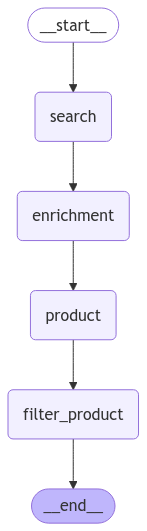

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

    pass

In [18]:
user_input="3 in(inch) schedule sch(schedule) 10 316 90s(90 short radius) 90 degree elbow"

In [19]:
import json
with open('context_data_3.json', 'r') as f:
    context_data = json.load(f)

In [20]:
context_data=[
    {
        "Product_id": "75fnte",
        "Manufacturer Part No. ": "75fnte",
        "description": "lock nut thin nylon insert measurement system imperial 3/4 - 16 thread",
        "stock_type": 1,
        "additional_information": {}
    }]

In [21]:
response = graph.invoke({
    "query":f"{user_input}",
    "products_list":context_data
})

d:\Yash-Python\Lib\site-packages\pydantic\json_schema.py:2179: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default='N/A', description='Name/Type of the product in the query'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
d:\Yash-Python\Lib\site-packages\pydantic\json_schema.py:2179: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default='N/A', description='Dimension of product'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [22]:
response['output_1']

{'Product': '90 degree elbow',
 'Dimension': '3 inch',
 'Enriched_Query': '3 inch Schedule 10 316 90 short radius 90 degree elbow ANSI B16.9 Butt Weld'}

In [23]:
(response['t_n_f_list'])

[{'Product': False,
  'Dimension': False,
  'Numerical_Entities': ['3', '10', '316', '90', '90'],
  'Non_Numerical_Entities': ['inch',
   'Schedule',
   'short radius',
   'degree',
   'elbow',
   'ANSI B16.9',
   'Butt Weld']}]

In [24]:
response['products_list']

[{'Product_id': '75fnte',
  'Manufacturer Part No. ': '75fnte',
  'description': 'lock nut thin nylon insert measurement system imperial 3/4 - 16 thread',
  'stock_type': 1,
  'additional_information': {}}]

In [25]:
response['output_2'].sort(key=lambda x: (x['Matching_Numerical_Entities'], x['Matching_Non_Numerical_Entities']), reverse=True)

In [26]:
response['output_2']

[]